In [13]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow import keras
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [14]:
pip install keras-tuner

In [16]:
pip install imblearn

**Run this cell if you have one file**

In [17]:
df=pd.read_csv('/content/drive/MyDrive/fv of enhancers positive negative file.csv')

X=df.drop(["positive","ngative"],axis=1)
y= df[["positive","ngative"]] # Use a list to select multiple columns

std_scalets = StandardScaler().fit(X)
X = std_scalets.fit_transform(X)
X = np.nan_to_num(X.astype('float32'))

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Run this cell if you have files train and test or positve and negative**

In [18]:
neg=pd.read_csv('/content/drive/MyDrive/ positive enhancers .csv')
pos=pd.read_csv('/content/drive/MyDrive/ non_enhancers nagative.csv')
df = pd.concat([neg, pos], ignore_index=True)

X=df.drop(["class"],axis=1)
y= df["class"]



std_scalets = StandardScaler().fit(X)
X = std_scalets.fit_transform(X)
X = np.nan_to_num(X.astype('float32'))

In [19]:
# ros = RandomOverSampler(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [20]:
#Set input_dim according the number of features in your dataset
input_dim=522


In [21]:
num_classes=2
# Reshape input data
import tensorflow as tf
X_train = X_train.reshape(-1, input_dim)
X_test = X_test.reshape(-1, input_dim)

# # Convert output data to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

**FCN**

Reloading Tuner from tuner_dir_final/tune_keras_model/tuner0.json
Epoch 1/20
236/236 [==============================] - 2s 5ms/step - loss: 0.6239 - accuracy: 0.7106 - val_loss: 0.5306 - val_accuracy: 0.7458
Epoch 2/20
236/236 [==============================] - 1s 5ms/step - loss: 0.5349 - accuracy: 0.7420 - val_loss: 0.5296 - val_accuracy: 0.7468
Epoch 3/20
236/236 [==============================] - 1s 5ms/step - loss: 0.5151 - accuracy: 0.7548 - val_loss: 0.5251 - val_accuracy: 0.7458
Epoch 4/20
236/236 [==============================] - 2s 6ms/step - loss: 0.4902 - accuracy: 0.7773 - val_loss: 0.5147 - val_accuracy: 0.7517
Epoch 5/20
236/236 [==============================] - 2s 7ms/step - loss: 0.4599 - accuracy: 0.7824 - val_loss: 0.5252 - val_accuracy: 0.7478
Epoch 6/20
236/236 [==============================] - 1s 6ms/step - loss: 0.4455 - accuracy: 0.7947 - val_loss: 0.5179 - val_accuracy: 0.7537
Epoch 7/20
236/236 [==============================] - 1s 5ms/step - loss: 0.4372 -

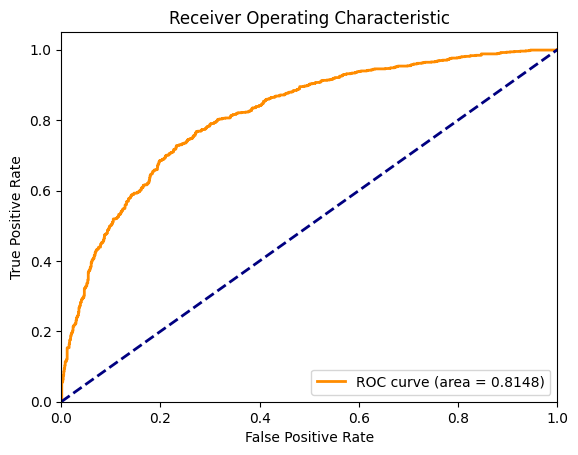

In [22]:
import numpy as np
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc, confusion_matrix
from keras.utils import to_categorical
import io

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=32),
        activation='relu',
        input_shape=(input_dim,)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def tune_and_train(X_train, y_train, X_test, y_test):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='tuner_dir_final',
        project_name='tune_keras_model'
    )

    tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

    best_hp = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best_hp)

    history = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    mcc = matthews_corrcoef(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes, average='macro')

    # Compute specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()
    specificity = tn / (tn + fp)

    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    # Capture the model summary
    summary = io.StringIO()
    model.summary(print_fn=lambda x: summary.write(x + "\n"))
    model_summary = summary.getvalue()

    return {
        'accuracy': acc,
        'mcc': mcc,
        'recall': recall,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'tpr': tpr,
        'fpr': fpr,
        'history': history,
        'model_summary': model_summary
    }

# Example usage:
# Assuming input_dim and num_classes are defined, and X_train, y_train, X_test, y_test are your data.
# input_dim = X_train.shape[1]
# num_classes = y_train.shape[1]  # if using one-hot encoding
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

results = tune_and_train(X_train, y_train, X_test, y_test)

print(f"Accuracy: {results['accuracy']}")
print(f"MCC: {results['mcc']}")
print(f"Recall: {results['recall']}")
print(f"Specificity: {results['specificity']}")
print(f"ROC AUC: {results['roc_auc']}")
print("Model Summary:")
print(results['model_summary'])

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results['fpr'], results['tpr'], color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % results['roc_auc'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**CNN**

Trial 5 Complete [00h 00m 17s]
val_accuracy: 0.7512363791465759

Best val_accuracy So Far: 0.7616221308708191
Total elapsed time: 00h 01m 22s
Epoch 1/20
472/472 [==============================] - 6s 7ms/step - loss: 0.5798 - accuracy: 0.7128 - val_loss: 0.5324 - val_accuracy: 0.7478
Epoch 2/20
472/472 [==============================] - 3s 5ms/step - loss: 0.5226 - accuracy: 0.7501 - val_loss: 0.5371 - val_accuracy: 0.7359
Epoch 3/20
472/472 [==============================] - 3s 6ms/step - loss: 0.5157 - accuracy: 0.7599 - val_loss: 0.5304 - val_accuracy: 0.7468
Epoch 4/20
472/472 [==============================] - 3s 6ms/step - loss: 0.5038 - accuracy: 0.7611 - val_loss: 0.5321 - val_accuracy: 0.7399
Epoch 5/20
472/472 [==============================] - 4s 8ms/step - loss: 0.4879 - accuracy: 0.7633 - val_loss: 0.5290 - val_accuracy: 0.7359
Epoch 6/20
472/472 [==============================] - 3s 6ms/step - loss: 0.4778 - accuracy: 0.7768 - val_loss: 0.5496 - val_accuracy: 0.7300
Epoch 

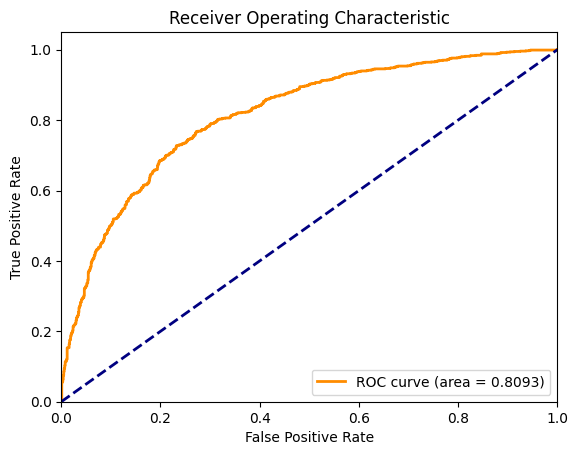

In [23]:
import numpy as np
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc, confusion_matrix
from keras.utils import to_categorical
import io

def build_model(hp):
    model = Sequential()

    # Adding the first Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
        activation='relu',
        input_shape=(input_dim, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Adding the second Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Adding the third Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_3', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())

    # Adding a dense layer before the output
    model.add(Dense(
        units=hp.Int('units_dense', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def tune_and_train_cnn(X_train, y_train, X_test, y_test):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=2,
        directory='tuner_dir_final_cnn',
        project_name='tune_keras_model'
    )

    tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

    best_hp = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best_hp)

    history = model.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    mcc = matthews_corrcoef(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes, average='macro')

    # Compute specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()
    specificity = tn / (tn + fp)

    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    # Capture the model summary
    summary = io.StringIO()
    model.summary(print_fn=lambda x: summary.write(x + "\n"))
    model_summary = summary.getvalue()

    return {
        'accuracy': acc,
        'mcc': mcc,
        'recall': recall,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'tpr': tpr,
        'fpr': fpr,
        'history': history,
        'model_summary': model_summary
    }

# Example usage:
# Assuming input_dim and num_classes are defined, and X_train, y_train, X_test, y_test are your data.
# For a 1D CNN, X_train and X_test should have shape (num_samples, input_dim, 1)
# input_dim = X_train.shape[1]
# num_classes = y_train.shape[1]  # if using one-hot encoding
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

results_cnn = tune_and_train_cnn(X_train, y_train, X_test, y_test)

print(f"Accuracy: {results_cnn['accuracy']}")
print(f"MCC: {results_cnn['mcc']}")
print(f"Recall: {results_cnn['recall']}")
print(f"Specificity: {results_cnn['specificity']}")
print(f"ROC AUC: {results_cnn['roc_auc']}")
print("Model Summary:")
print(results_cnn['model_summary'])

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results['fpr'], results['tpr'], color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % results_cnn['roc_auc'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**SImple RNN**

In [24]:
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [25]:
# Reshape input data
timestamp=1
X_train = X_train.reshape(X_train.shape[0], timestamp, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], timestamp, X_test.shape[1])


<ipython-input-27-b0bad8a3a384>:37: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(rnn, best_model_path)


32/32 [==============================] - 0s 2ms/step
RNN
Best Validation Accuracy: 0.752720057964325
Test Accuracy: 0.7527200791295747
Test MCC: 0.5105085631255938
Test Specificity: 0.8187250996015937
Test Sensitivity (Recall TPR): 0.68762278978389


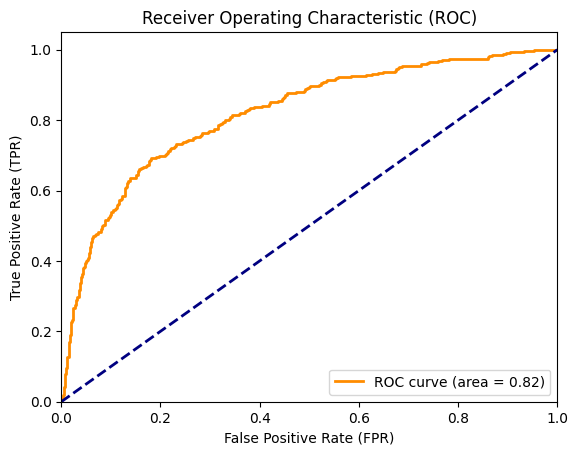

In [27]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_rnn(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    timestamp = 1
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    rnn = Sequential()
    rnn.add(SimpleRNN(64, return_sequences=True, input_shape=(timestamp, 522)))
    rnn.add(Dropout(0.5))
    rnn.add(SimpleRNN(32, return_sequences=True))
    rnn.add(Dropout(0.5))
    rnn.add(SimpleRNN(16))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(128, activation='relu'))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(64, activation='relu'))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = rnn.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = f'best_model_rnn.h5'
    save_model(rnn, best_model_path)

    # Evaluate the best model on test data
    rnn_best = rnn  # Load the best model from file if needed
    y_test_pred = rnn_best.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=0)
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=1)

    # Compute ROC curve
    fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(y_test_true_labels, y_test_pred[:, 1])  # Adjust if needed based on class ordering
    roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

    # Print metrics
    print("RNN")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Specificity:", test_specificity)
    print("Test Sensitivity (Recall TPR):", test_sensitivity)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_rnn, tpr_rnn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rnn)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_rnn, tpr_rnn, roc_auc_rnn

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_rnn, tpr_rnn, roc_auc_rnn = train_evaluate_rnn(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


<ipython-input-16-457c9003d31c>:37: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(lstm, best_model_path)


24/24 [==============================] - 1s 3ms/step
LSTM
Best Validation Accuracy: 0.8746702075004578
Test Accuracy: 0.8680738786279684
Test MCC: 0.7016952411252214
Test Specificity: 0.8895348837209303
Test Sensitivity (Recall TPR): 0.8223140495867769


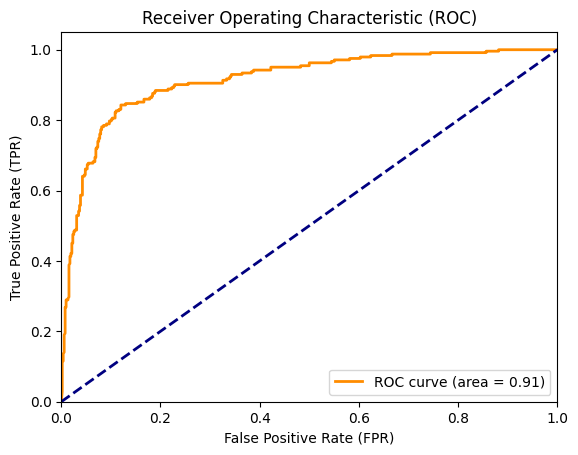

In [ ]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_lstm(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    timestamp = 1
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    lstm = Sequential()
    lstm.add(LSTM(64, return_sequences=True, input_shape=(timestamp, 522)))
    lstm.add(Dropout(0.5))
    lstm.add(LSTM(32, return_sequences=True))
    lstm.add(Dropout(0.5))
    lstm.add(LSTM(16))
    lstm.add(Dropout(0.5))
    lstm.add(Dense(128, activation='relu'))
    lstm.add(Dropout(0.5))
    lstm.add(Dense(64, activation='relu'))
    lstm.add(Dropout(0.5))
    lstm.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = f'best_model_lstm.h5'
    save_model(lstm, best_model_path)

    # Evaluate the best model on test data
    lstm_best = lstm  # Load the best model from file if needed
    y_test_pred = lstm_best.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=0)
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=1)

    # Compute ROC curve
    fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test_true_labels, y_test_pred[:, 1])  # Adjust if needed based on class ordering
    roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

    # Print metrics
    print("LSTM")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Specificity:", test_specificity)
    print("Test Sensitivity (Recall TPR):", test_sensitivity)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lstm)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_lstm, tpr_lstm, roc_auc_lstm

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path_lstm, test_accuracy_lstm, test_mcc_lstm, test_specificity_lstm, test_sensitivity_lstm, fpr_lstm, tpr_lstm, roc_auc_lstm = train_evaluate_lstm(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


<ipython-input-18-43b5684061d7>:37: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(gru_model, best_model_path)


24/24 [==============================] - 1s 3ms/step
GRU
Best Validation Accuracy: 0.8799472451210022
Test Accuracy: 0.8693931398416886
Test MCC: 0.7042827235845892
Test Specificity: 0.8914728682170543
Test Sensitivity (Recall TPR): 0.8223140495867769


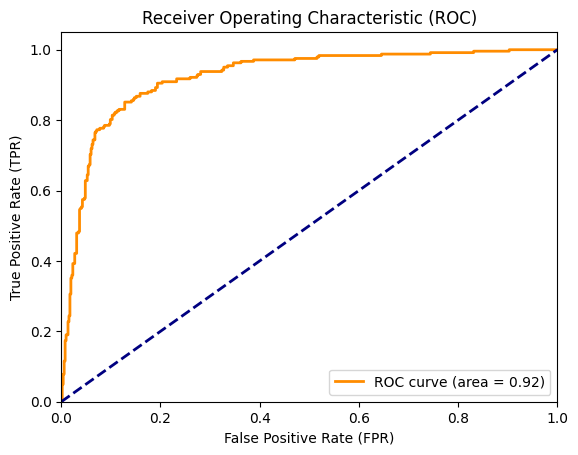

In [ ]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_gru(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    timestamp = 1
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    gru_model = Sequential()
    gru_model.add(GRU(64, return_sequences=True, input_shape=(None, 522)))
    gru_model.add(Dropout(0.5))
    gru_model.add(GRU(32, return_sequences=True))
    gru_model.add(Dropout(0.5))
    gru_model.add(GRU(16))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(128, activation='relu'))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(64, activation='relu'))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = f'best_model_gru.h5'
    save_model(gru_model, best_model_path)

    # Evaluate the best model on test data
    gru_best = gru_model  # Load the best model from file if needed
    y_test_pred = gru_best.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=0)
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=1)

    # Compute ROC curve
    fpr_gru, tpr_gru, thresholds_gru = roc_curve(y_test_true_labels, y_test_pred[:, 1])  # Adjust if needed based on class ordering
    roc_auc_gru = auc(fpr_gru, tpr_gru)

    # Print metrics
    print("GRU")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Specificity:", test_specificity)
    print("Test Sensitivity (Recall TPR):", test_sensitivity)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_gru, tpr_gru, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gru)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_gru, tpr_gru, roc_auc_gru

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_gru, tpr_gru, roc_auc_gru = train_evaluate_gru(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


<ipython-input-19-d90cb83140c9>:37: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(bilstm_model, best_model_path)


24/24 [==============================] - 2s 4ms/step
Bidirectional LSTM (Bi-LSTM)
Best Validation Accuracy: 0.8733509182929993
Test Accuracy: 0.8601583113456465
Test MCC: 0.683744347005312
Test Specificity: 0.8837209302325582
Test Sensitivity (Recall TPR): 0.8099173553719008


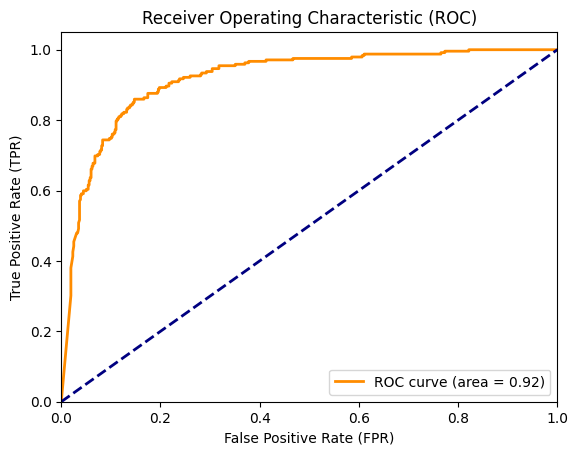

In [ ]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_bilstm(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    timestamp = 1
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    bilstm_model = Sequential()
    bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timestamp, 522)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Bidirectional(LSTM(32, return_sequences=True)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Bidirectional(LSTM(16)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(128, activation='relu'))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(64, activation='relu'))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = bilstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = f'best_model_bilstm.h5'
    save_model(bilstm_model, best_model_path)

    # Evaluate the best model on test data
    bilstm_best = bilstm_model  # Load the best model from file if needed
    y_test_pred = bilstm_best.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=0)
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=1)

    # Compute ROC curve
    fpr_bilstm, tpr_bilstm, thresholds_bilstm = roc_curve(y_test_true_labels, y_test_pred[:, 1])  # Adjust if needed based on class ordering
    roc_auc_bilstm = auc(fpr_bilstm, tpr_bilstm)

    # Print metrics
    print("Bidirectional LSTM (Bi-LSTM)")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Specificity:", test_specificity)
    print("Test Sensitivity (Recall TPR):", test_sensitivity)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_bilstm, tpr_bilstm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_bilstm)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_bilstm, tpr_bilstm, roc_auc_bilstm

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_bilstm, tpr_bilstm, roc_auc_bilstm = train_evaluate_bilstm(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


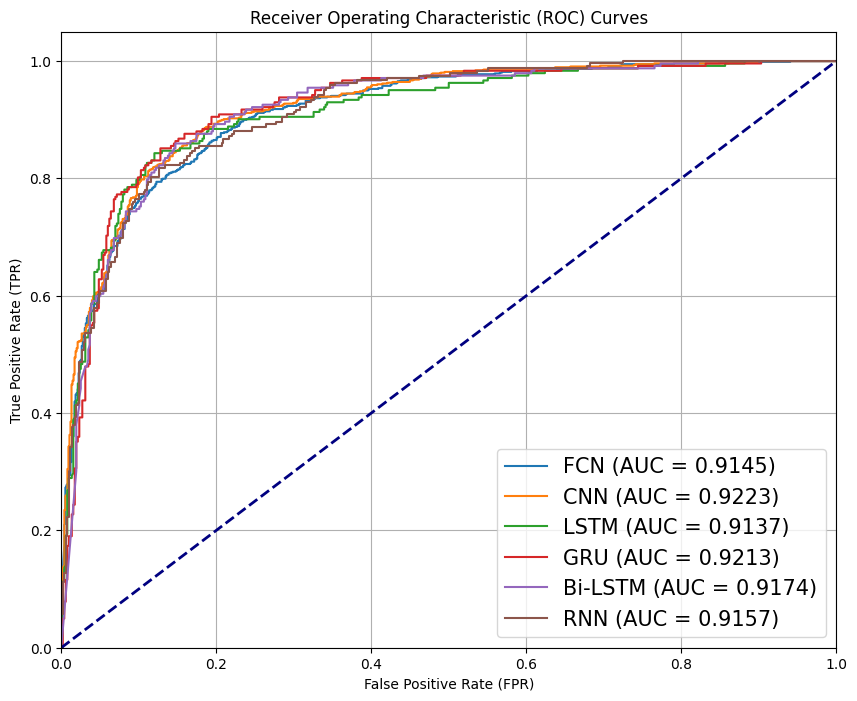

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
models = ['FCN', 'CNN', 'LSTM', 'GRU', 'Bi-LSTM', 'RNN']
auc_scores = [results['roc_auc'], results_cnn['roc_auc'],roc_auc_lstm,roc_auc_gru,roc_auc_bilstm,roc_auc_rnn]
fpr_models = {
    'FCN': results['fpr'],
    'CNN': results_cnn['fpr'],
    'LSTM': fpr_lstm,
    'GRU': fpr_gru,
    'Bi-LSTM': fpr_bilstm,
    'RNN': fpr_rnn
}
tpr_models = {
    'FCN': results['tpr'],
    'CNN': results_cnn['tpr'],
    'LSTM': tpr_lstm,
    'GRU': tpr_gru,
    'Bi-LSTM': tpr_bilstm,
    'RNN': tpr_rnn
}

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model in models:
    plt.plot(fpr_models[model], tpr_models[model], label=f'{model} (AUC = {auc_scores[models.index(model)]:.4f})')

# Plotting settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right", fontsize=15, ncol=1)
plt.grid(True)
plt.show()
